In [1]:
import os
import sys
import torch
import h5py
import logging
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from omegaconf import OmegaConf
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from tqdm import tqdm
from hydra import compose, initialize
from diffusion_pde.models.loss import Loss


logger = logging.getLogger()       # get root logger (or replace with your module logger)
logger.setLevel(logging.INFO)      # make sure INFO level is shown

# If there is no handler yet, add one
if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

In [2]:
root_dir = dpde.utils.get_repo_root()
data_dir = root_dir / "data" 
dataset_name = "heat_logt.hdf5"
data_path = data_dir / dataset_name

In [3]:
method = "forward"
dataset = f"heat_eq_{method}"
start_at_t0 = True
epochs = 5
model = "unetv2"

In [4]:
with initialize(config_path="../conf", job_name="debug_job", version_base=None):
    cfg = compose(
        config_name="train",
        overrides=[
            f"dataset={dataset}",
            f"dataset.start_at_t0={start_at_t0}",
            f"dataset.training.num_epochs={epochs}",
            f"model={model}"
            ]
        )

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

edm = dpde.utils.get_net_from_config(cfg)

In [6]:
dataloader = dpde.datasets.get_dataloader(cfg)

#edm.to(device);

In [7]:
wand_kwargs = OmegaConf.to_container(cfg.wandb, resolve=True)
wand_kwargs["mode"] = "disabled"
print("WandB config:", wand_kwargs)

save_path = dpde.utils.get_repo_root() / "logs"
print("Saving to:", save_path)

WandB config: {'entity': 'philiphohwy-danmarks-tekniske-universitet-dtu', 'project': 'dynamical-pde-diffusion-final', 'dir': '/home/s204790/logs', 'name': 'None', 'mode': 'disabled'}
Saving to: /home/s204790/dynamical-pde-diffusion/logs


In [8]:
def X_and_dXdt_fd(net, x, sigma, labels, eps=1e-5, **kwargs):
    lbl_p = labels.clone(); lbl_m = labels.clone()
    lbl_p[:, 0] += eps
    lbl_m[:, 0] -= eps
    up = net(x, sigma, lbl_p, **kwargs)
    um = net(x, sigma, lbl_m, **kwargs)
    u0 = net(x, sigma, labels, **kwargs)
    dudt_fd = (up - um) / (2*eps)
    del up, um, lbl_p, lbl_m
    return u0, dudt_fd

In [9]:
def heat_pde_loss(u, dudt, labels, dx=1.0):
    alpha = labels[:, 1].view(-1, 1, 1, 1)
    laplacian_u = dpde.sampling.laplacian(u, dx)
    loss_pde = torch.mean((dudt - alpha * laplacian_u) ** 2, dim=(1,2,3))
    return loss_pde

class EDMPhysicsLoss(Loss):
    def __init__(self, 
        pde_loss_fn, 
        pde_loss_kwargs,
        pde_loss_coeff=1.0, 
        ch_a=0,
        P_mean=-1.2, 
        P_std=1.2, 
        sigma_data=0.5, 
        reduce_method="mean"
        ):
        self.pde_loss_fn = pde_loss_fn
        self.pde_loss_kwargs = pde_loss_kwargs
        self.pde_loss_coeff = pde_loss_coeff
        self.ch_a = ch_a
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data
        self.reduce_method = reduce_method

    def __call__(self, net, x, labels, **kwargs):
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=x.device)
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        n = torch.randn_like(x, device=x.device) * sigma
        D_yn, dxdt = X_and_dXdt_fd(net, x + n, sigma.flatten(), labels, **kwargs)
        dxdt = dxdt.detach()
        dxdt = dxdt[:, self.ch_a:, ...]  # select channel for PDE loss
        #D_yn = net(x + n, sigma.flatten(), *args, **kwargs)
        edm_loss = weight * ((D_yn - x) ** 2)

        if self.reduce_method == "mean":
            edm_loss = edm_loss.mean(dim=(1,2,3))
        elif self.reduce_method == "sum":
            edm_loss = edm_loss.sum(dim=(1,2,3))

        pde_loss = self.pde_loss_fn(D_yn[:, self.ch_a:, ...], dxdt, labels, **self.pde_loss_kwargs)

        loss = edm_loss + self.pde_loss_coeff * pde_loss
        
        return loss

In [13]:
ch_a = cfg.dataset.net.in_ch // 2 if method == "joint" else 0

loss_fn = EDMPhysicsLoss(
    pde_loss_fn=heat_pde_loss,
    pde_loss_kwargs={"dx": 1.0},
    pde_loss_coeff=0.01,
    ch_a=ch_a
)

In [14]:
edm.to(device)

next_dict = next(iter(dataloader))
print("Batch keys:", next_dict.keys())

for key in next_dict:
    next_dict[key] = next_dict[key].to(device)

X = next_dict.pop("X")
labels = next_dict.pop("labels")

loss = loss_fn(edm, X, labels, **next_dict).mean()
print(loss.item())
del next_dict, X, labels, loss

edm.to("cpu")

torch.cuda.empty_cache()
torch.cuda.synchronize()

Batch keys: dict_keys(['obs', 'X', 'labels'])
0.04177099093794823


In [12]:
epochs = 50

dpde.training.train(
    model=edm,
    dataloader=dataloader,
    loss_fn=loss_fn,
    device=device,
    epochs=epochs,
    lr=cfg.dataset.training.learning_rate,
    weight_decay=cfg.dataset.training.weight_decay,
    wandb_kwargs=wand_kwargs,
    save_path=save_path
)

2025-11-19 18:18:22,659 - INFO - initializing wandb run for training
2025-11-19 18:18:23,162 - INFO - starting training loop
2025-11-19 18:18:34,680 - INFO - Epoch [1/50] - Loss: 0.268757
2025-11-19 18:18:46,092 - INFO - Epoch [2/50] - Loss: 0.070887
2025-11-19 18:18:57,511 - INFO - Epoch [3/50] - Loss: 0.044749
2025-11-19 18:19:09,299 - INFO - Epoch [4/50] - Loss: 0.036359
2025-11-19 18:19:20,796 - INFO - Epoch [5/50] - Loss: 0.031701
2025-11-19 18:19:32,110 - INFO - Epoch [6/50] - Loss: 0.030062
2025-11-19 18:19:43,541 - INFO - Epoch [7/50] - Loss: 0.029482
2025-11-19 18:19:55,417 - INFO - Epoch [8/50] - Loss: 0.028694
2025-11-19 18:20:06,908 - INFO - Epoch [9/50] - Loss: 0.027363
2025-11-19 18:20:18,290 - INFO - Epoch [10/50] - Loss: 0.026466
2025-11-19 18:20:29,718 - INFO - Epoch [11/50] - Loss: 0.024313
2025-11-19 18:20:41,135 - INFO - Epoch [12/50] - Loss: 0.025857
2025-11-19 18:20:52,544 - INFO - Epoch [13/50] - Loss: 0.024390
2025-11-19 18:21:03,997 - INFO - Epoch [14/50] - Los

Traceback (most recent call last):
  File "/home/s204790/dynamical-pde-diffusion/src/diffusion_pde/training/training_loop.py", line 65, in train
    torch.save(model.state_dict(), save_path)
    ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/torch/serialization.py", line 966, in save
    with _open_zipfile_writer(f) as opened_zipfile:
         ~~~~~~~~~~~~~~~~~~~~^^^
  File "/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/torch/serialization.py", line 828, in _open_zipfile_writer
    return container(name_or_buffer)  # type: ignore[arg-type]
  File "/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/torch/serialization.py", line 792, in __init__
    torch._C.PyTorchFileWriter(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self.name, get_crc32_options(), _get_storage_alignment()
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
RuntimeError: File /hom

RuntimeError: File /home/s204790/dynamical-pde-diffusion/logs cannot be opened.

In [14]:
torch.save(edm.state_dict(), root_dir / "pretrained_models" / "debug_model.pth")

In [15]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
edm.load_state_dict(torch.load(root_dir / "pretrained_models" / "debug_model.pth"))

<All keys matched successfully>

In [16]:
num_params = sum(p.numel() for p in edm.parameters() if p.requires_grad)
param_GB = num_params * 4 / 1e9  # assuming 32-bit floats

print(f"total trainable parameters: {num_params / 1e6:.2f} million")
print(f"approximate memory usage for parameters: {param_GB:.2f} GB")

total trainable parameters: 7.04 million
approximate memory usage for parameters: 0.03 GB


In [17]:
with h5py.File(data_dir / "heat_lineart_validate.hdf5", "r") as f:
    A_v = f["A"][:]
    U_v = f["U"][:]
    labels_v = f["labels"][:]
    t_steps_v = f["t_steps"][:]
    attrs_v = dict(f.attrs)

dx = attrs_v["dx"]
dy = attrs_v["dy"]
T = attrs_v["T"]

In [18]:
idx = 0   # which sample to visualize
t_idx = 20  # which time step to visualize

t = t_steps_v[t_idx].item()
lbl = labels_v[idx, :]
a = A_v[idx, :]  # (S, S)
u = U_v[idx, :, :, :, t_idx]  # (S, S)

a.shape, u.shape

((1, 64, 64), (1, 64, 64))

In [19]:
sample_shape = (16, *cfg.dataset.sampling.sample_shape)
generator = torch.Generator().manual_seed(0)

interior_a = 1.0
boundary_a = 1.0

interior_u = 0.0
boundary_u = 0.0

boundary_obs_a = dpde.validation.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_a)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_a)

boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_u)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_u)
mask_a = dpde.validation.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

In [20]:
def edm_sampler2(
    net,            # EDMWrapper (calls Unet inside)
    device,         # device to run the sampler on  
    sample_shape,   # (B, C, H, W) shape of samples
    loss_fn,        # loss function to compute gradients
    loss_fn_kwargs, # extra args to pass to loss function
    labels,         # (B, label_dim) extra conditioning your Unet expects; use zeros if None
    zeta_a=1.0,     # weight for obs_a loss
    zeta_u=1.0,     # weight for obs_u loss
    zeta_pde=1.0,   # weight for pde loss
    num_steps=18,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
    to_cpu=True,
    generator=None,
    return_losses=False,
):
    net.eval()

    dtype_f = torch.float32     # net runs in fp32
    dtype_t = torch.float64     # keep time grid in fp64 for stability, as in EDM

    B = sample_shape[0]
    
    net.to(device=device)
        
    labels = labels.to(device=device, dtype=dtype_f)    # move labels to correct device and dtype

    if generator is None:
        generator = torch.Generator(device=device)

    # Initial sample at sigma_max
    latents = torch.randn(sample_shape, device=device, generator=generator)
    
    # Move loss function kwargs to correct device and dtype
    for key, val in loss_fn_kwargs.items():
        if isinstance(val, torch.Tensor):
            loss_fn_kwargs[key] = val.to(device=device, dtype=dtype_t)

    # Discretize sigmas per EDM (Karras et al. 2022), t_N = 0 appended.
    step_idx = torch.arange(num_steps, dtype=dtype_t, device=device)
    sigmas = (sigma_max**(1.0/rho) + step_idx/(num_steps-1) * (sigma_min**(1.0/rho) - sigma_max**(1.0/rho)))**rho
    sigmas = getattr(net, "round_sigma", lambda x: x)(sigmas)
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])])  # length N+1, last = 0

    # Initialize x at sigma_0
    x_next = (latents.to(dtype_t) * sigmas[0])

    losses = torch.zeros((num_steps, 4))  # for debugging
    
    for i, (sigma_cur, sigma_next) in enumerate(zip(sigmas[:-1], sigmas[1:])):  # i = 0..N-1
        x_cur = x_next.detach().clone()
        x_cur.requires_grad = True
        #x_hat = x_cur
        # Euler step to t_next
        x_N, dxdt = dpde.sampling.X_and_dXdt(net, x_cur.to(dtype_f), torch.full((B,), sigma_cur, device=device, dtype=dtype_f), labels)
        x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
        d_cur = (x_cur - x_N) / sigma_cur
        x_next = x_cur + (sigma_next - sigma_cur) * d_cur

        # Heun (2nd-order) correction unless final step
        if i < num_steps - 1:
            x_N, dxdt = dpde.sampling.X_and_dXdt(net, x_next.to(dtype_f), torch.full((B,), sigma_next, device=device, dtype=dtype_f), labels)
            x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
            d_prime = (x_next - x_N) / sigma_next
            x_next = x_cur + (sigma_next - sigma_cur) * (0.5 * d_cur + 0.5 * d_prime)

        # Compute losses
        loss_pde, loss_a, loss_obs_u = loss_fn(x_N, dxdt, **loss_fn_kwargs)

        if i <= 0.8 * num_steps:
            w_a, w_u, w_pde = zeta_a, zeta_u, zeta_pde
        else:
            w_a, w_u, w_pde = 0.1 * zeta_a, 0.1 * zeta_u, zeta_pde

        loss_comb = w_a * loss_a + w_u * loss_obs_u + w_pde * loss_pde
        grad_x = torch.autograd.grad(loss_comb, x_cur, retain_graph=False)[0]
        x_next = x_next - grad_x
        
        losses[i] = torch.tensor([loss_a.item(), loss_obs_u.item(), loss_pde.item(), loss_comb.item()])

        x_cur.grad = None
        del x_N, x_cur, dxdt, loss_pde, loss_a, loss_obs_u, loss_comb, grad_x


    for key, val in loss_fn_kwargs.items():
        if isinstance(val, torch.Tensor):
            loss_fn_kwargs[key] = val.to(device="cpu", dtype=dtype_f)


    # Return at sigma=0 in fp32
    x = x_next.to(dtype_f).detach()
    if to_cpu:
        x = x.cpu()

    losses = losses.detach().cpu().numpy() if return_losses else None

    return x, losses

In [24]:
torch.cuda.empty_cache()

obs_a = torch.tensor(a)
obs_u = torch.tensor(u)

ch_a = 1

#sample_shape = (32, 2, 64, 64)

zeta_a = 50.0
zeta_u = 20.0
zeta_pde = 0.0

num_steps = 23

t_cond = torch.full((sample_shape[0], 1), t)
lbl1 = torch.tensor(lbl).unsqueeze(0).repeat(sample_shape[0], 1)
lbls = torch.cat([t_cond.cpu(), lbl1.cpu()], dim=-1)


loss_fn_kwargs = {
    "obs_a": obs_a,
    "obs_u": obs_u,
    "mask_a": mask_a,
    "mask_u": mask_u,
    "dx": dx,
    "dy": dx,
    "ch_a": ch_a,
    "labels": lbl1,
}

torch.backends.cudnn.conv.fp32_precision = 'tf32'

#for i in range(10):
samples, losses = dpde.sampling.edm_sampler(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=dpde.sampling.heat_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=lbls,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    to_cpu=True,
    debug=False,
    return_losses=True,
    compile_net=False,
)
print(f"Final total loss: {losses[-1, 3]:.4f}")

Final total loss: 51.2902


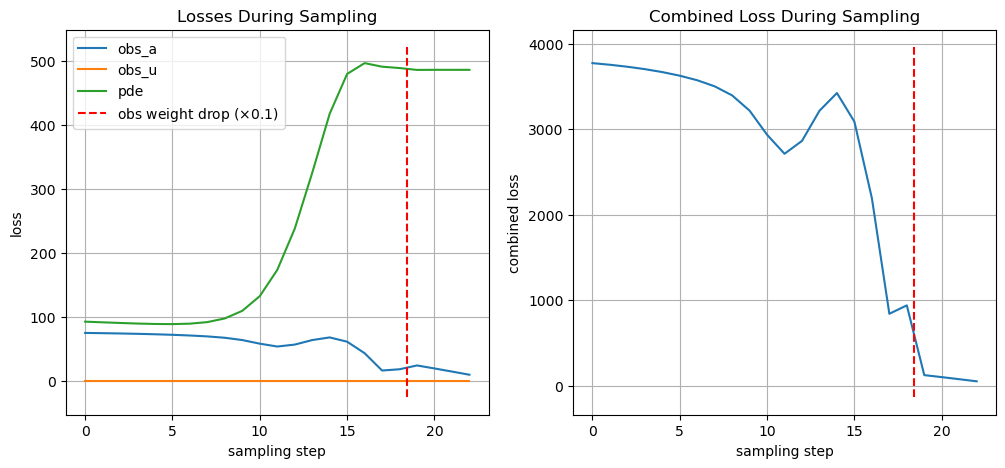

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

In [26]:
print(f"Total memory: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.2f} GB")
print(f"Allocated memory: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")
print(f"Reserved memory: {torch.cuda.memory_reserved(device) / 1024**3:.2f} GB")

Total memory: 31.36 GB
Allocated memory: 0.13 GB
Reserved memory: 12.74 GB


RMSE Initial Condition: 0.0206
RMSE Solution at t=0.500: 0.5585


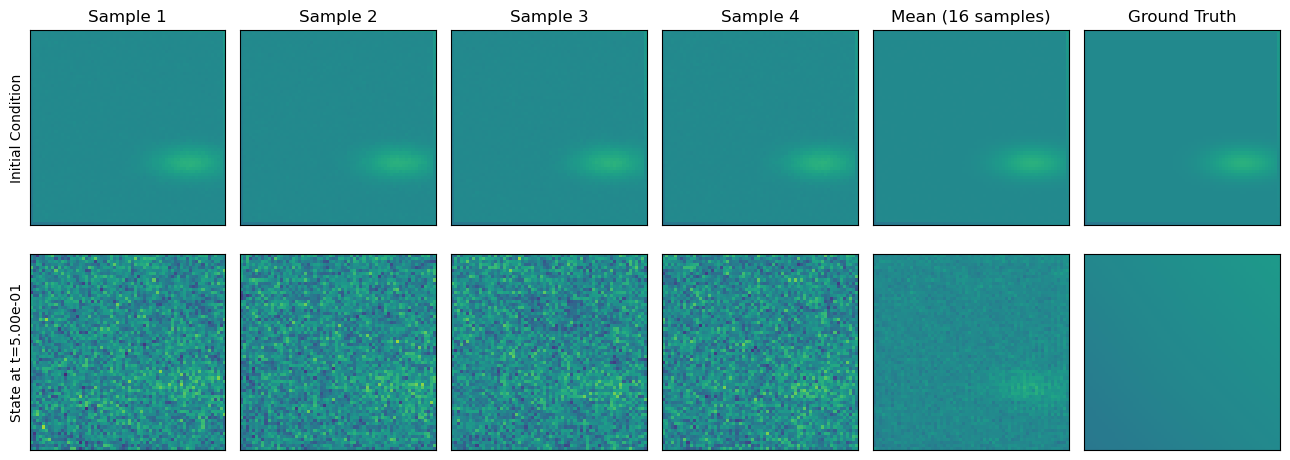

In [27]:
mean_val = samples.mean(axis=0)

vmin = min(samples[:].min(), obs_a.min(), obs_u.min())
vmax = max(samples[:].max(), obs_a.max(), obs_u.max())

print(f"RMSE Initial Condition: {torch.sqrt(torch.mean((samples[:, 0] - obs_a)**2)):.4f}")
print(f"RMSE Solution at t={T:.3f}: {torch.sqrt(torch.mean((samples[:, 1] - obs_u)**2)):.4f}")

fig, axs = plt.subplots(2, 6, figsize=(13, 5))
for i in range(4):
    axs[0, i].imshow(samples[i, 0], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0, i].set(aspect="equal", xticks=[], yticks=[])
    axs[0, i].set_title(f'Sample {i+1}')
    if i == 0:
        axs[0, i].set_ylabel('Initial Condition')
    axs[1, i].imshow(samples[i, 1], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1, i].set(aspect="equal", xticks=[], yticks=[])
    if i == 0:
        axs[1, i].set_ylabel(f'State at t={T:.2e}')

axs[0, 4].imshow(mean_val[0], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 4].set(aspect="equal", xticks=[], yticks=[], title=f"Mean ({sample_shape[0]} samples)")
axs[1, 4].imshow(mean_val[1], cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 4].set(aspect="equal", xticks=[], yticks=[])

axs[0, 5].imshow(obs_a.numpy().squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 5].set(aspect="equal", xticks=[], yticks=[], title="Ground Truth")
axs[1, 5].imshow(obs_u.numpy().squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 5].set(aspect="equal", xticks=[], yticks=[])
plt.tight_layout()